# SARcasm

**A Jupyter notebook for helping [me] make sense of sysstat sar data.**

Copyright (c) 2017 Brendon Caligari, London, UK

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.
    
    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.
    
    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

Strategy:
* Export one, or possibly more, sysstat ```.sa``` files as XML
* Import the sar data from XML into pandas dataframes
* Provide reference code for manipulation and visualisation of the various metrics

Tested and assumed to work with:
* SLES 11 SP[34]
* Ubuntu 16.4

### Usage

As sysstat evolved so did the file format used to stor the sar data and unfortunately there is no guarantee that a version of ```sadf``` can read ```.sa``` files created with an earlier version of ```sa```.  Thankfully, different versions of sar data file format and sysstat version used can be determined from the file header.
```sadf``` can export ```.sa``` files into various formats.  XML outpout has been available *consistently* since [at least] sysstat version 8.1.5 and proved to be the most umambiquous and complete format for this script's objectives.

#### Sysstat binaries

For every ```.sa``` file version an ```sadf``` binary capable of exporting its contents to XML is required.  This mapping from file version to binary is maintained in the dict ```sa_exporters``` class variable for class ```SarData```.

#### Files to analyse

Which ```.sa``` files to analyse and the directory where they are found is set in the ```sa_files``` list and the ```sa_directory``` variables respectively in the **Importing sa files** sections.  It is sensible that consequitive daily sar files from the same host are used for a meaningful time series.

#### Analysing the data

The section **Sanity checks** outputs metadata collected from the input files and describes the data frames used to store the collected information.  The **Plots** section provides templates for frequently rquired plot.  The idea however is for those plots to be modified or added to as required.

#### System requirements

* Python3
* Jupyter
* pandas
* Should be fine with Anaconda [Python3]

### KNOWN ISSUES

* **This is a bodged together ugly hack not a proper application**
* We are rudely abusing XML both in principle and practice
* TODO compile a table of known file formats and compatible sysstat versions
* TODO include link to ```sysstat``` versions
* TODO include links to various sysstat binary downloads
* Heavy refactoring is required

In [1]:
sa_directory = './z1'
sa_files = ["sa05", "sa06", 'sa07', 'sa08', 'sa09', 'sa10', 'sa11', 'sa12', 'sa13']

In [2]:
import xml.etree.ElementTree as ET
import pandas as pd
import subprocess
from datetime import datetime
import matplotlib
%matplotlib inline

In [3]:
class SarData(object):
    """Class for importing sar data"""
    
    sa_file_magic = "96d5"
    
    sa_exporters = {
        "2170": ["./sadf.binaries/sles11sp3/usr/bin/sadf", "-x", "-t", "--", "-A"],
        "2173": ["/usr/bin/sadf", "-x", "-t", "--", "-A"]
    }

    @classmethod
    def sa_get_version(cls, filename):
        """Checks an sa file for sysstat sa magic and returns file format version"""
        with open(filename, mode="rb") as f:
            magic = f.read(2)
            if magic != bytes.fromhex(cls.sa_file_magic):
                raise TypeError("{} does not start with sa file magic. Got 0x{:02x}{:02x}".format(
                    filename, magic[1], magic[0]))
            format_version = f.read(2)
            return "{:02x}{:02x}".format(format_version[1], format_version[0])

    @classmethod
    def sa_to_xml(cls, filename):
        """Open an sa file and export it to XML"""
        sa_ver = cls.sa_get_version(filename)
        if not sa_ver in cls.sa_exporters:
            raise NotImplementedError("No exporter for {} format version {}".format(filename, sa_ver))
        return subprocess.check_output(cls.sa_exporters[sa_ver] + [filename])
    
    def __init__(self):
        self.hostname = None            # hostname within sa file
        self.aggregate0 = None          # aggregate of what we pull out of the xml
        self.aggregate1 = None
        self.hostmeta = None
        self._raw_aggregate0 = list()
        self._raw_metadata = list()
        
    def import_file(self, filename):
        """Import an sa file"""
        # XML output from sadf seems to have developed 'evolutionarily' with namespaces
        # thrown in at some point for added inconvenience.  Here we strip them out.
        raw_xml = self.sa_to_xml(filename)      # Read in the xml output of sadf
        xml_tree = ET.fromstring(raw_xml)       # Convert to ET elements
        __class__._strip_xml_ns(xml_tree)       # Remove XML namespace crap inplace
        if xml_tree.tag != "sysstat":
            raise TypeError("Expected 'sysstat' but found a root of {}".format(xml_tree.tag))
        for level1 in xml_tree:
            if level1.tag == 'sysdata-version':
                pass
            elif level1.tag == "host":
                tmp_hostmeta = {'filename': filename}
                if "nodename" in level1.attrib:
                    tmp_hostmeta['nodename'] = level1.attrib["nodename"]
                for host_child in level1:
                    if host_child.tag == "statistics":
                        for timestamp in host_child:
                            if timestamp.tag != "timestamp":
                                print("  Unexpected statistic tag: {}".timestamp.tag)
                                continue
                            datum_time = datetime.strptime(timestamp.attrib["date"] +
                                                           "T" + timestamp.attrib["time"],
                                                           "%Y-%m-%dT%H:%M:%S")
                            tmp_datum0 = {'timestamp': datum_time}
                            for metric in timestamp:
                                # Simple key value statistics for regular polls will all go
                                # into a single dict 'aggregate0'
                                aggregate0_parser = self.get_aggregate0_parser(metric.tag)
                                if aggregate0_parser:
                                    tmp_datum0.update(aggregate0_parser(metric))
                            self._raw_aggregate0.append(tmp_datum0)
                    else:
                        hostmeta_parser = self.get_hostmeta_parser(host_child.tag)
                        if hostmeta_parser:
                            tmp_hostmeta[host_child.tag] = hostmeta_parser(host_child)
                        else:
                            print("Unexpected host tag: {}".format(host_child.tag))
                self._raw_metadata.append(tmp_hostmeta)
            else:
                print("Unknown level 1: {}".format(child_tag))
        pass
        
    def dicts_to_dataframes(self):
        """Convert the various temporary lists of dicts to Data Frames"""
        self.aggregate0 = pd.DataFrame.from_dict(self._raw_aggregate0)
        self.hostmeta = pd.DataFrame.from_dict(self._raw_metadata)
    
    def fix_numeric_columns(self):
        """Convert necessary Data Frame columns from str to numeric"""
        for sa_column in self.aggregate0.columns:
            if sa_column == 'timestamp':
                continue
            sa.aggregate0[sa_column] = pd.to_numeric(sa.aggregate0[sa_column],
                                                     errors='coerce')

    @classmethod
    def _strip_xml_ns(cls, element):
        element.tag = element.tag.split('}')[-1]
        for child in element:
            cls._strip_xml_ns(child)

    @classmethod
    def get_hostmeta_parser(cls, meta_tag):
        """Returns a parser for elements under 'host'"""
        ## we can comment out any problematic ones at runtime
        meta_parsers = {
            'sysname': cls._parse_meta_default,
            'release': cls._parse_meta_default,
            'comments': cls._parse_meta_default,
            'restarts': cls._parse_meta_default,
            'machine': cls._parse_meta_default,
            'number-of-cpus': cls._parse_meta_default,
            'file-date': cls._parse_meta_default,
            'file-utc-time': cls._parse_meta_default
        }
        if meta_tag in meta_parsers:
            return meta_parsers[meta_tag]
        return None
        
    @classmethod
    def get_aggregate0_parser(cls, metric_tag):
        """Returns a parser for elements under 'host->statistics'"""
        ## we can comment out any problematic ones at runtime
        metric_parsers = {
            'queue': cls._parse_absorb_level,
            'memory': cls._parse_absorb_level,
            'process-and-context-switch': cls._parse_absorb_level,
            'hugepages': cls._parse_absorb_level,
            'paging': cls._parse_absorb_level,
            'io': cls._parse_absorb_level,
            'swap-pages': cls._parse_absorb_level,
            'kernel': cls._parse_absorb_level
        }
        if metric_tag in metric_parsers:
            return metric_parsers[metric_tag]
        return None

    @staticmethod
    def _parse_meta_default(element):
        """returns text field of a sar metadata element"""
        return element.text.strip()
    
    @staticmethod
    def _parse_absorb_level(element):
        """returns a dict of flattened attributes and element tags with some cleanup"""
        tmp_dict = dict()
        for child in element:
            tmp_dict[child.tag] = child.text
        tmp_dict.update(element.attrib.copy())
        for undesired in ['per', 'unit']:
            if undesired in tmp_dict:
                tmp_dict.pop(undesired)
        return tmp_dict
    
    def plot_simple_aggregate0(self, y_vars):
        """simple timeseries from self.aggregate0 columns"""
        plot = None
        try:
            sa.aggregate0.plot(x=['timestamp'],
                               y=y_vars,
                               style='-',
                               figsize=(15, 10))
        except KeyError as err:
            print("KeyError: {}".format(err))
        return plot

## Importing ```sa``` files

Here we extract the various entries within the sar file and populate appropriate data frames.  The process is deliberately iterative and verbose to expose the various fields and make on the fly modification or manual reproduction of steps easier. *It does however need to be heavily refactored regardless.*

In [4]:
sa = SarData()

for sa_file in map(lambda sa_file: "{}/{}".format(sa_directory, sa_file), sa_files):
    sa_xml = sa.import_file(sa_file)

sa.dicts_to_dataframes()
sa.fix_numeric_columns()

## Sanity checks

In [5]:
sa.hostmeta

,file-date,file-utc-time,filename,machine,nodename,number-of-cpus,release,restarts,sysname
0,2017-10-05,23:00:01,./z1/sa05,x86_64,elysium,8,4.10.0-35-generic,,Linux
1,2017-10-06,23:00:01,./z1/sa06,x86_64,elysium,8,4.10.0-35-generic,,Linux
2,2017-10-07,23:00:01,./z1/sa07,x86_64,elysium,8,4.10.0-35-generic,,Linux
3,2017-10-08,23:00:01,./z1/sa08,x86_64,elysium,8,4.10.0-35-generic,,Linux
4,2017-10-09,23:00:01,./z1/sa09,x86_64,elysium,8,4.10.0-35-generic,,Linux
5,2017-10-10,23:00:01,./z1/sa10,x86_64,elysium,8,4.10.0-35-generic,,Linux
6,2017-10-11,23:00:01,./z1/sa11,x86_64,elysium,8,4.10.0-35-generic,,Linux
7,2017-10-12,23:00:01,./z1/sa12,x86_64,elysium,8,4.10.0-35-generic,,Linux
8,2017-10-13,23:00:01,./z1/sa13,x86_64,elysium,8,4.10.0-35-generic,,Linux


In [6]:
sa.aggregate0.dtypes

active                      int64
anonpg                      int64
blocked                     int64
buffers                     int64
bufpg                     float64
cached                      int64
campg                     float64
commit                      int64
commit-percent            float64
cswch                     float64
dentunusd                   int64
dirty                       int64
fault                     float64
file-nr                     int64
frmpg                     float64
hugfree                     int64
hugused                     int64
hugused-percent           float64
inactive                    int64
inode-nr                    int64
io-reads                  float64
io-writes                 float64
kstack                      int64
ldavg-1                   float64
ldavg-15                  float64
ldavg-5                   float64
majflt                    float64
memfree                     int64
memused                     int64
memused-percen

## Plots

### Queue length and load averages

* ```ldavg-1``` - System load average over past 1 minute
* ```ldavg-5``` - System load average over past 5 minutes
* ```ldavg-15``` - System load average over past 15 minutes

From ```uptime(1)```:

       System load averages is the average number of processes that are either
       in a runnable or uninterruptable state.  A process in a runnable  state
       is  either using the CPU or waiting to use the CPU.  A process in unin‐
       terruptable state is waiting for some I/O access, eg waiting for  disk.
       The  averages  are  taken over the three time intervals.  Load averages
       are not normalized for the number of CPUs in a system, so a load  aver‐
       age  of 1 means a single CPU system is loaded all the time while on a 4
       CPU system it means it was idle 75% of the time.

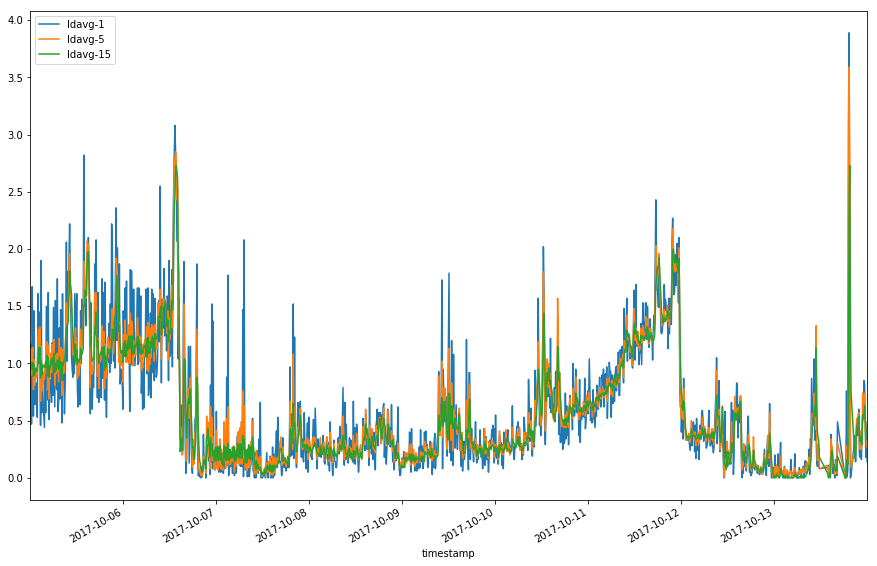

In [7]:
sa.plot_simple_aggregate0(['ldavg-1', 'ldavg-5', 'ldavg-15'])

* ```runq-sz``` - number of tasks waiting to run
* ```plist-sz``` - number of tasks in process list

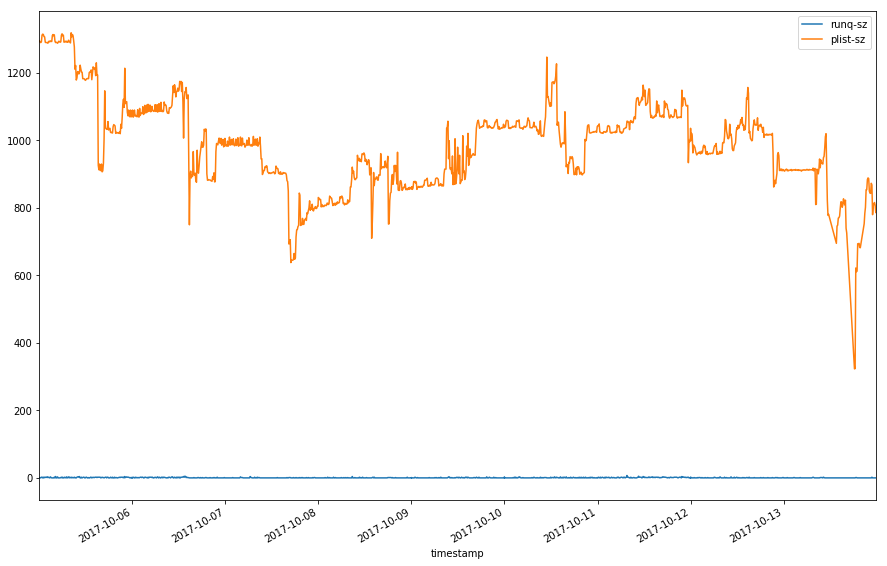

In [8]:
sa.plot_simple_aggregate0(['runq-sz', 'plist-sz'])

### Memory utilisation statistics

* ```memfree``` - kb free memory available
* ```memused``` - kb memory used
* ```buffers``` - kb kernel buffers buffers
* ```cached``` - kb page cache and slabs
* ```swpused``` - kb used swap space

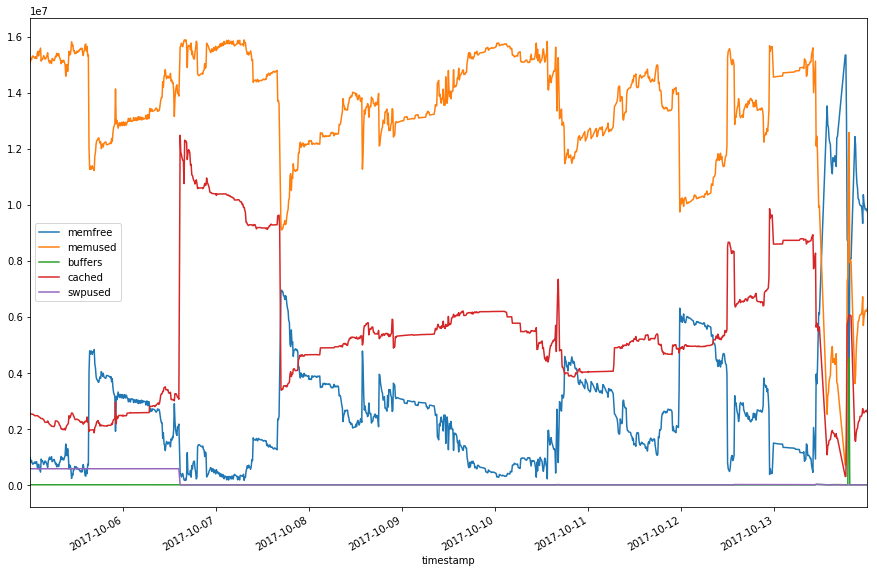

In [9]:
sa.plot_simple_aggregate0(['memfree', 'memused', 'buffers', 'cached', 'swpused'])

* ```memused-percent``` - percentage memory used
* ```swpused-percent``` - percentage swap used

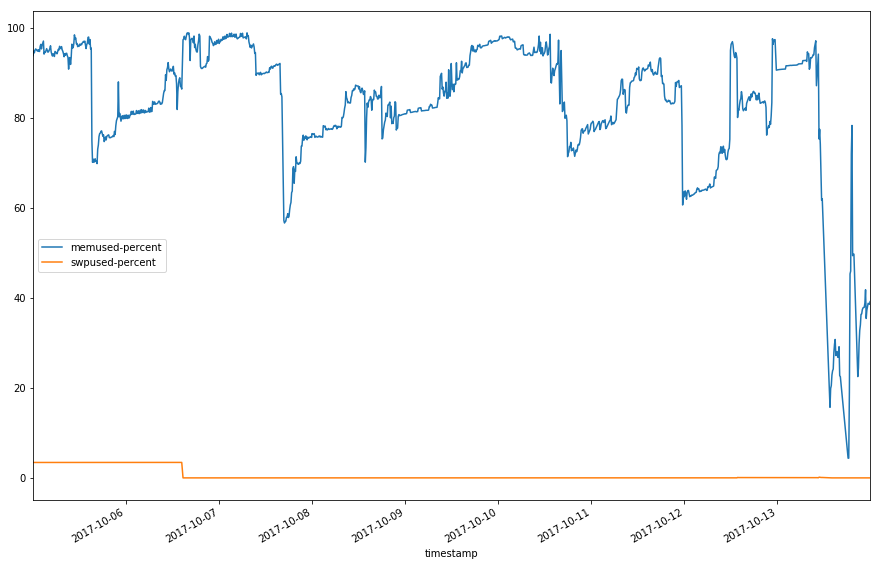

In [10]:
sa.plot_simple_aggregate0(['memused-percent', 'swpused-percent'])

### Swapping statistics

* ```pswpin``` -
* ```pswpout``` -

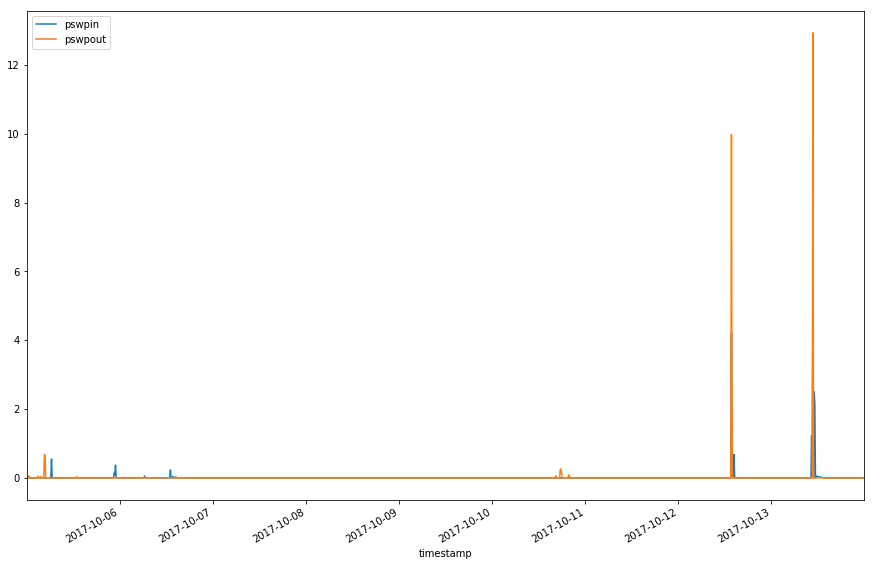

In [11]:
sa.plot_simple_aggregate0(['pswpin', 'pswpout'])

### Task creation and system switching

* ```proc``` - tasks created per second

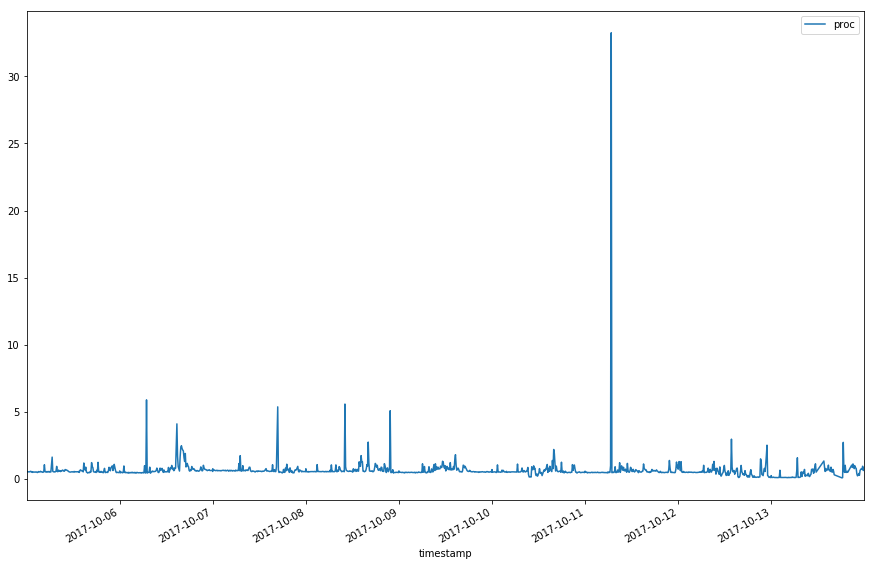

In [12]:
sa.plot_simple_aggregate0(['proc'])

* ```cswch``` - context switches per second

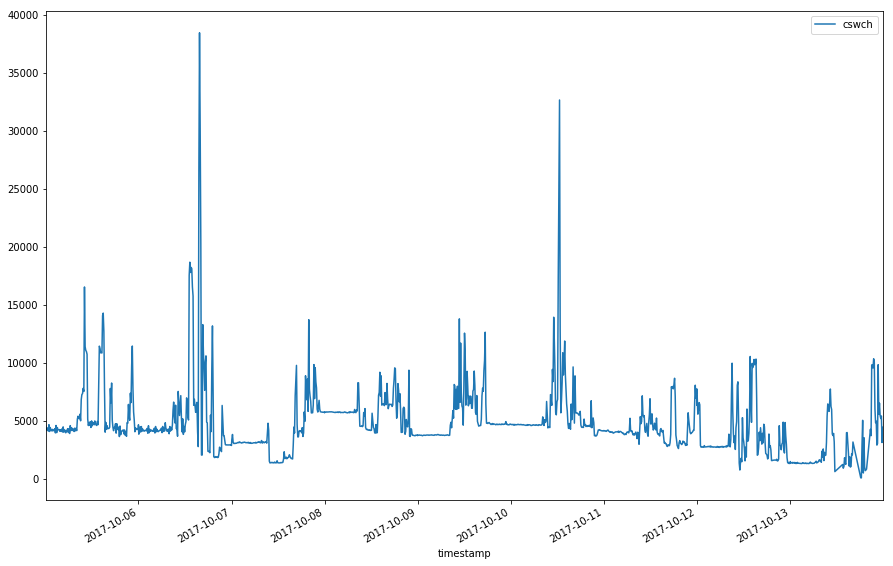

In [13]:
sa.plot_simple_aggregate0(['cswch'])

### Huge pages utilisation

* ```hugused``` -
* ```hugfree``` -

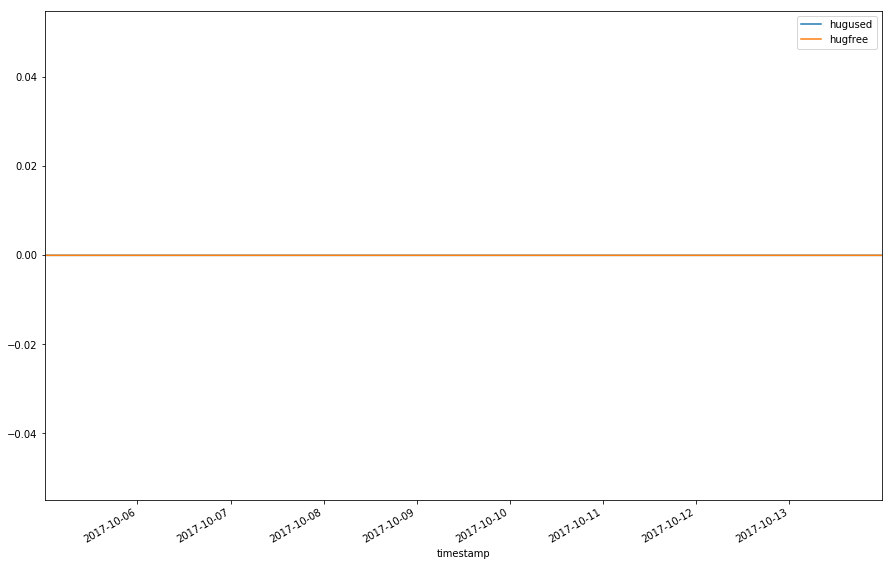

In [14]:
sa.plot_simple_aggregate0(['hugused', 'hugfree'])    

* ```hugused-percent```

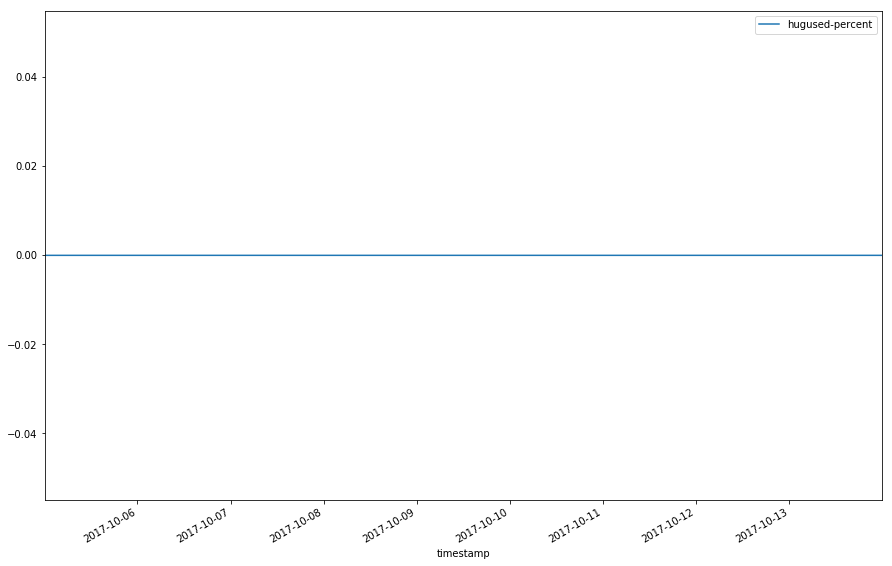

In [15]:
sa.plot_simple_aggregate0(['hugused-percent'])

### IO and transfar rate statistics

* ```tps``` - Transfers per second to physical devices

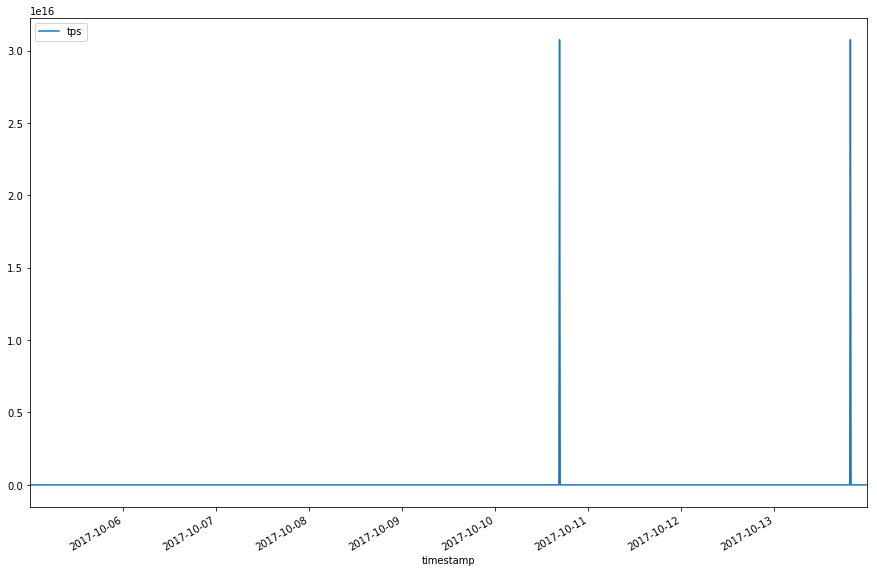

In [16]:
sa.plot_simple_aggregate0(['tps'])

* ```rtps``` -
* ```wtps``` -

In [17]:
sa.plot_simple_aggregate0(['rtps', 'wtps'])

KeyError: "['rtps' 'wtps'] not in index"


* ```bread``` -
* ```bwrtn``` -

In [18]:
sa.plot_simple_aggregate0(['bread', 'bwrtn'])

KeyError: "['bread' 'bwrtn'] not in index"


### Paging statistics

* ```pgpgin``` -
* ```pgpgout``` -
* ```fault``` -
* ```majflt``` -
* ```pgfree``` -
* ```pgscank``` -
* ```pgscand``` -
* ```pgsteal``` -

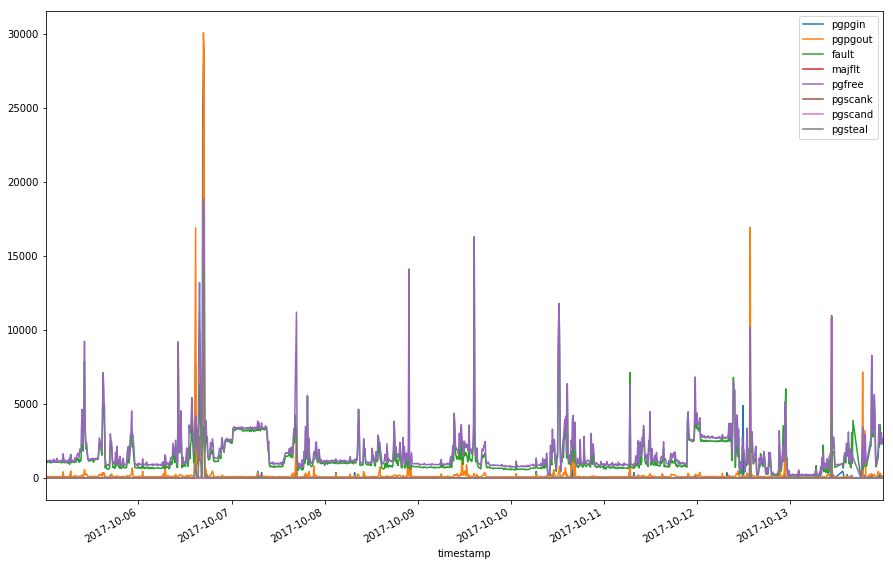

In [19]:
sa.plot_simple_aggregate0(['pgpgin', 'pgpgout', 'fault', 'majflt', 'pgfree', 'pgscank', 'pgscand', 'pgsteal'])

* ```vmeff-percent``` -

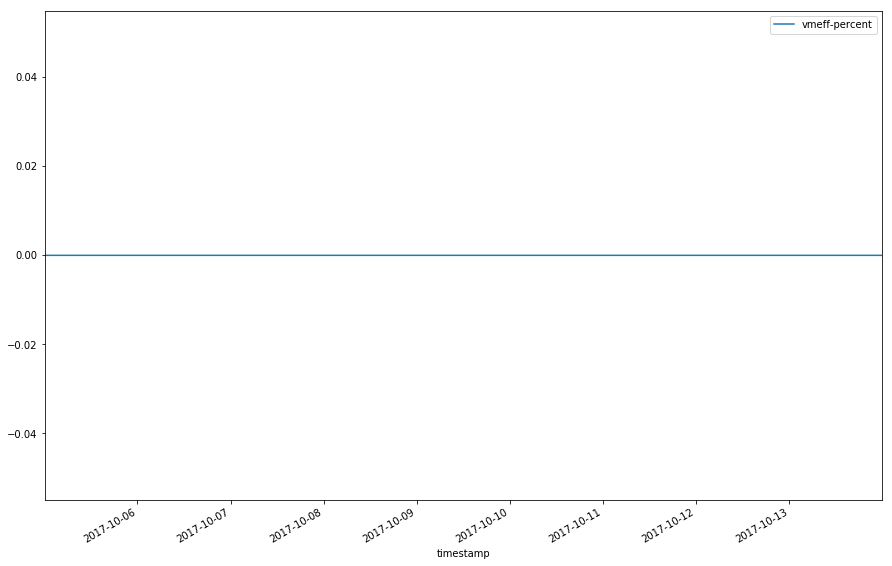

In [20]:
sa.plot_simple_aggregate0(['vmeff-percent'])

### Kernel table statistics

* ```dentunusd``` - unused entries in directory cache

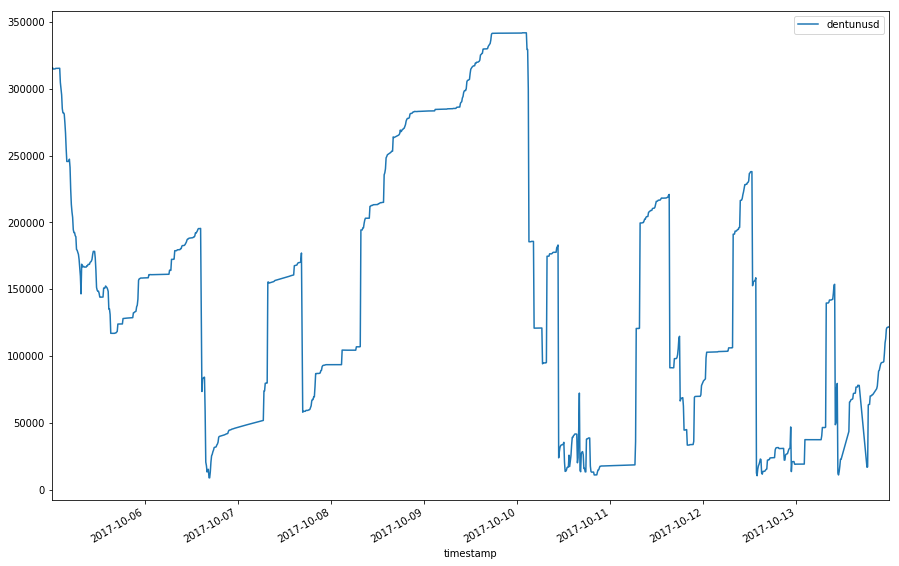

In [21]:
sa.plot_simple_aggregate0(['dentunusd'])

* ```file-nr``` - file handles in use

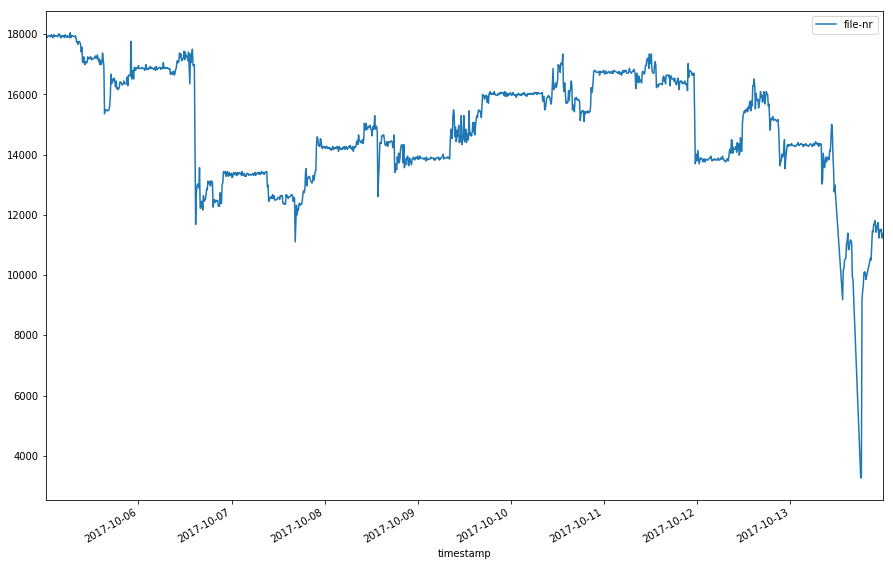

In [22]:
sa.plot_simple_aggregate0(['file-nr'])

* ```inode-nr``` - inode handles in use

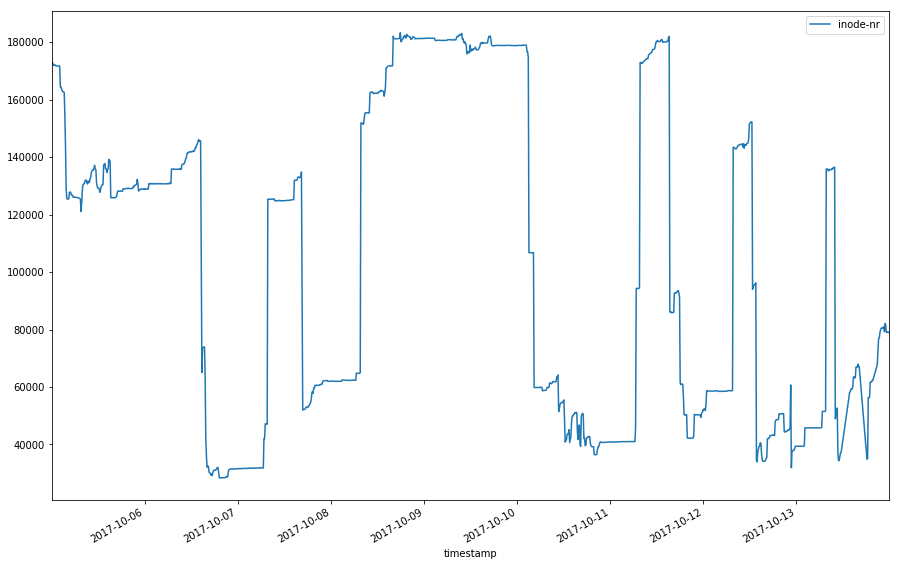

In [23]:
sa.plot_simple_aggregate0(['inode-nr'])

* ```pty-nr``` - pseudo-terninals in use

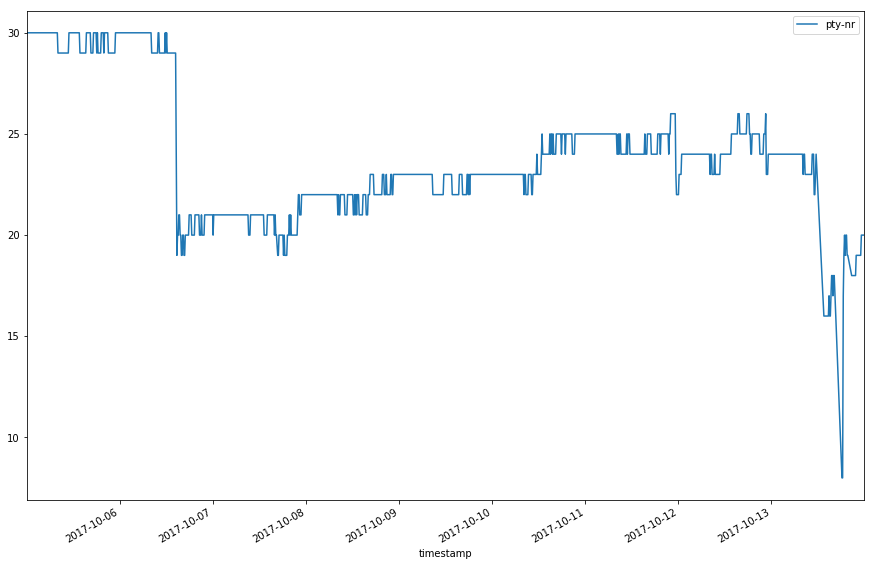

In [24]:
sa.plot_simple_aggregate0(['pty-nr'])